In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from time import time
import matplotlib.pyplot as plt
from pandas.core.reshape.pivot import pivot_table 
% matplotlib inline
plt.style.use("ggplot")

In [2]:
user = pd.read_csv('BX-Users.csv', encoding="ISO-8859-1")
user.head()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_id,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [3]:
book = pd.read_csv('BX-Books.csv', encoding="ISO-8859-1")
book.head()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [4]:
rating = pd.read_csv('BX-Book-Ratings.csv', nrows=10000, encoding="ISO-8859-1")
rating.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
user_id    10000 non-null int64
isbn       10000 non-null object
rating     10000 non-null int64
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [6]:
user.describe()

,Age
count,168096.000000
mean,34.751434
std,14.428097
min,0.000000
25%,24.000000
50%,32.000000
75%,44.000000
max,244.000000


In [7]:
book.describe()

,isbn,book_title,book_author,year_of_publication,publisher
count,271379,271379,271378,271379,271377
unique,271379,242150,102042,202,16823
top,876056125,Selected Poems,Agatha Christie,2002,Harlequin
freq,1,27,632,17145,7535


In [8]:
rating.describe()

,user_id,rating
count,10000.000000,10000.000000
mean,265844.379600,1.974700
std,56937.189618,3.424884
min,2.000000,0.000000
25%,277478.000000,0.000000
50%,278418.000000,0.000000
75%,278418.000000,4.000000
max,278854.000000,10.000000


## 1. Clean data and get rating data

#### Only rating table is useful for the task

In [9]:
# raings of stars attribute
rating['rating'].value_counts()

0     7354
8      630
7      516
9      410
10     393
5      294
6      254
4       72
3       48
2       20
1        9
Name: rating, dtype: int64

In [10]:
# Number of unique isbn
rating['isbn'].nunique()

9335

In [11]:
# Number of unique user id
rating['user_id'].nunique()

941

In [12]:
# user count
df_user_count = rating['user_id'].value_counts()
df_user_count.head()

278418    4533
277427     497
277639     270
277478     214
278188     197
Name: user_id, dtype: int64

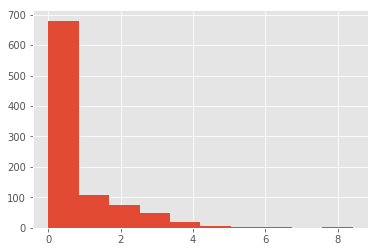

In [13]:
# display log histogram
# df_user_counts.hist()
df_user_count.apply(np.log).hist()
plt.show()

#### There are many users that haven't given many reviews, exclude these users from the item-item similarity recommender

### Q: How do we recommend to these users anyways?

In [14]:
# Number of users who give the reviews once

df_user_count[df_user_count == 1].sum()

592

In [15]:
# Number of users who give the reviews 5 times
df_user_count[df_user_count == 5].sum()

90

In [29]:
df_user_count;

We consider the number of reviews which is over 5 times as the users who have given many reviews

In [16]:
df_user_count = df_user_count[df_user_count > 5]

In [17]:
# Number of users who give review more than 5
df_user_count.sum()

8843

In [18]:
# df_user_count index
df_user_count.index

Int64Index([278418, 277427, 277639, 277478, 278188,    183, 278137, 276925,
            277195, 278144,
            ...
            277109, 277627, 278449, 277197, 276800, 276746,     69,    232,
            278663, 277107],
           dtype='int64', length=153)

In [19]:
# Reorder dataframe
df_cleaned = rating.set_index('user_id').ix[df_user_count.index].reset_index()
df_cleaned.head()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,user_id,isbn,rating
0,278418,6128831,0
1,278418,6542808,5
2,278418,20209606,0
3,278418,20418809,0
4,278418,20420900,0


In [20]:
# df_cleaned index
df_cleaned.index

RangeIndex(start=0, stop=8843, step=1)

Create utility matrix from records¶

In [21]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8843 entries, 0 to 8842
Data columns (total 3 columns):
user_id    8843 non-null int64
isbn       8843 non-null object
rating     8843 non-null int64
dtypes: int64(2), object(1)
memory usage: 207.3+ KB


In [22]:
# convert to document, word like matrix
df_utility = pd.pivot_table(data=df_cleaned,
                            values='rating', # fill with stars
                            index='user_id', # rows
                            columns='isbn', # columns
                            fill_value=0) # fill missings

In [23]:
df_utility.head()

isbn,002043300X,002542730X,003008685X,003021436X,006008216X,006015957X,006016848X,006020883X,006054094X,006091291X,...,99460343,99565404,99604302,99675404,99743612,99845008,99908506,9995585227,B0000BLD7X,N3453124715
user_id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Item-Item similarity recommender

In [24]:
# To be implemented
class ItemItemRecommender(object):

    def __init__(self, neighborhood_size):
        self.neighborhood_size = neighborhood_size

    def fit(self, ratings_mat):
        self.ratings_mat = ratings_mat
        self.n_users = ratings_mat.shape[0]
        self.n_items = ratings_mat.shape[1]
        self.item_sim_mat = cosine_similarity(self.ratings_mat.T)
        self._set_neighborhoods()

    def _set_neighborhoods(self):
        least_to_most_sim_indexes = np.argsort(self.item_sim_mat, 1)
        self.neighborhoods = least_to_most_sim_indexes[:, -self.neighborhood_size:]

    def pred_one_user(self, user_id, report_run_time=False):
        start_time = time()
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        # Just initializing so we have somewhere to put rating preds
        out = np.zeros(self.n_items)
        for item_to_rate in range(self.n_items):
            relevant_items = np.intersect1d(self.neighborhoods[item_to_rate],
                                            items_rated_by_this_user,
                                            assume_unique=True)  # assume_unique speeds up intersection op
            out[item_to_rate] = self.ratings_mat[user_id, relevant_items] * \
                self.item_sim_mat[item_to_rate, relevant_items] / \
                self.item_sim_mat[item_to_rate, relevant_items].sum()
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        cleaned_out = np.nan_to_num(out)
        return cleaned_out

    def pred_all_users(self, report_run_time=False):
        start_time = time()
        all_ratings = [
            self.pred_one_user(user_id) for user_id in range(self.n_users)]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return np.array(all_ratings)

    def top_n_recs(self, user_id, n):
        pred_ratings = self.pred_one_user(user_id)
        item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                        if item not in items_rated_by_this_user]
        return unrated_items_by_pred_rating[-n:]


def get_ratings_data():
   
    ratings_as_mat=scipy.sparse.csr_matrix(df_utility.values)
    
    return df_cleaned, ratings_as_mat

In [35]:
# To be implemented
df_ratings_contents, ratings_mat = get_ratings_data()
my_rec_engine = ItemItemRecommender(neighborhood_size=75)
my_rec_engine.fit(ratings_mat)
user_1_preds = my_rec_engine.pred_one_user(user_id=79, report_run_time=True)
# Show predicted ratings for user #1 on first 100 items
#print(user_1_preds[:100])
print(my_rec_engine.top_n_recs(2, 20))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Execution time: 4.356419 seconds
[2814, 2813, 2812, 2811, 2810, 2795, 8413, 2802, 2796, 2807, 2806, 2805, 2804, 2797, 2803, 2808, 2801, 2800, 2799, 2798]


## 3. Matrix Factorization recommender¶

#### Compare two of the methods demoed in Practice Class: sklearn NMF, sklearn TruncatedSVD, or GraphLab

## NMF

In [31]:
from sklearn.decomposition import NMF

def fit_nmf(M,k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W = nmf.transform(M);
    H = nmf.components_;
    err = nmf.reconstruction_err_
    return W,H,err

# decompose
W,H,err = fit_nmf(ratings_mat,100)
print(err)
print(W.shape,H.shape)

82.34319219158226
(153, 100) (100, 8414)


In [32]:
# reconstruct
ratings_mat_fitted = W.dot(H)
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print(mse)
print(average_abs_err)

3.419348779527103
0.5081735048763789


In [33]:
# get recommendations for one user
user_id = 100
n = 10

pred_ratings = ratings_mat_fitted[user_id,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[:n]

[6646, 6085, 7430, 199, 6503, 6142, 4877, 4554, 5034, 5061]

In [34]:
### check errors
# truth
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()
# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]
print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))
err_one_user = ratings_true-ratings_pred
print(err_one_user)
print(abs(err_one_user).mean())

[(10, 9.999999999974358), (10, 9.999999999974358), (10, 9.999999999974358), (10, 9.999999999974358), (10, 9.999999999974358), (10, 9.999999999974358), (10, 9.999999999974358), (5, 5.0000000003589795)]
[[ 2.56417110e-11  2.56417110e-11  2.56417110e-11  2.56417110e-11
   2.56417110e-11  2.56417110e-11  2.56417110e-11 -3.58979513e-10]]
6.730893620243705e-11
